https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/03.%20Feature%20Engineering/03.%20Feature%20Engineering.ipynb

https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/06.%20MT%20-%20Random%20Forest.ipynb

https://towardsdatascience.com/text-classification-in-python-dd95d264c802

https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training



1. Read in the data
2. Test train split
3. use TFIFD to add in the new features
4. Use an algorithm to make some predictions
5. Assess the accuracy

In [1]:
DATA_IN_FOLDER : str = "../data/out/"
DATA_OUT_FOLDER : str = "../data/out/"

RANDOM_STATE : int = 42
    
SOURCE_TRAINING_DATA_FILE : str = "Womens Clothing E-Commerce Reviews with Emotions.xlsx"
SOURCE_FULL_DATA_FILE : str = "Womens Clothing E-Commerce Reviews.xlsx"
UTILITIES_PATH : str = r'C:\Users\GHarrison\OneDrive - Lincoln College\Python Projects\Data Science\Utilities'
MODEL_FILE : str = "ml_model.pkl"
VECTORIZER_FILE : str = "vectorizer.pkl"

EMOTIONS : list = ['Joy', 'Sadness', 'Fear', 'Anger']
RESAMPLE : bool = True
    
TFIDF_NGRAM_RANGE : tuple = (1,2)
TFIDF_MAX_DF : float = 1.
TFIDF_MIN_DF : int = 10
TFIDF_MAX_FEATURES : int = 300
    
NUM_FOLDS : int = 5
SCORING :str = 'accuracy'
RANDOM_STATE : int = 42
VERBOSE : int = 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import sys
sys.path.insert(1, UTILITIES_PATH)

from misc_tools import load_object, save_object

In [3]:
df_reviews = pd.read_excel(f"{DATA_IN_FOLDER}{SOURCE_TRAINING_DATA_FILE}")
df_reviews.dropna(inplace=True) 
df_reviews.reset_index(drop=True, inplace=True)

In [4]:
df_reviews.head()

,index,Review Title,Review Text,Review Rating,Review Positive Feedback Count,Review Polarity,Review Sentiment,Review Subjectivity,Review Length,Review Word Count,...,Reviewer Age,Reviewer Age Category,Emotion,Emotion Score,Division,Department,Product ID,Product Name,Product Category,Recommended?
0,1,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,0,0.550000,Positive,0.250000,124,22,...,50,45-54,Joy,0.972142,General Petite,Bottoms,1049,Product 1049,Pants,1
1,2,Flattering shirt,This shirt is very flattering to all due to th...,5,6,0.512891,Positive,0.137500,192,36,...,47,45-54,Joy,0.844207,General,Tops,847,Product 847,Blouses,1
2,3,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,4,0.178750,Positive,0.066250,488,98,...,49,45-54,Joy,0.668897,General,Dresses,1080,Product 1080,Dresses,0
3,4,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,0.133750,Positive,0.215556,496,101,...,39,35-44,Joy,0.573683,General Petite,Tops,858,Product 858,Knits,1
4,5,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,4,0.171635,Positive,-0.007692,482,97,...,39,35-44,Joy,0.554208,General Petite,Tops,858,Product 858,Knits,1


In [5]:
#emotion_map = {
#    'Joy': 0,
#    'Sadness': 1,
#    'Fear': 2,
#    'Anger': 3
#}

#reverse_emotion_map = {v:k for k,v in emotion_map.items()} 

In [6]:
df_reviews.rename(columns={"Emotion": "Emotion Code"}, inplace=True)
#df_reviews['Emotion Code'] = df_reviews['Emotion']
#df_reviews = df_reviews.replace({'Emotion Code': emotion_map})
df_reviews.head()

,index,Review Title,Review Text,Review Rating,Review Positive Feedback Count,Review Polarity,Review Sentiment,Review Subjectivity,Review Length,Review Word Count,...,Reviewer Age,Reviewer Age Category,Emotion Code,Emotion Score,Division,Department,Product ID,Product Name,Product Category,Recommended?
0,1,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,0,0.550000,Positive,0.250000,124,22,...,50,45-54,Joy,0.972142,General Petite,Bottoms,1049,Product 1049,Pants,1
1,2,Flattering shirt,This shirt is very flattering to all due to th...,5,6,0.512891,Positive,0.137500,192,36,...,47,45-54,Joy,0.844207,General,Tops,847,Product 847,Blouses,1
2,3,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,4,0.178750,Positive,0.066250,488,98,...,49,45-54,Joy,0.668897,General,Dresses,1080,Product 1080,Dresses,0
3,4,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,0.133750,Positive,0.215556,496,101,...,39,35-44,Joy,0.573683,General Petite,Tops,858,Product 858,Knits,1
4,5,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,4,0.171635,Positive,-0.007692,482,97,...,39,35-44,Joy,0.554208,General Petite,Tops,858,Product 858,Knits,1


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753 entries, 0 to 1752
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           1753 non-null   int64  
 1   Review Title                    1753 non-null   object 
 2   Review Text                     1753 non-null   object 
 3   Review Rating                   1753 non-null   int64  
 4   Review Positive Feedback Count  1753 non-null   int64  
 5   Review Polarity                 1753 non-null   float64
 6   Review Sentiment                1753 non-null   object 
 7   Review Subjectivity             1753 non-null   float64
 8   Review Length                   1753 non-null   int64  
 9   Review Word Count               1753 non-null   int64  
 10  Review Text Cleaned             1753 non-null   object 
 11  Review Text Wordcloud           1753 non-null   object 
 12  Reviewer Age                    17

In [8]:
df_reviews_train, df_reviews_val = train_test_split(df_reviews, test_size=0.2, random_state = RANDOM_STATE)
df_reviews_train.reset_index(drop=True, inplace=True)
df_reviews_val.reset_index(drop=True, inplace=True)

In [9]:
# Upsample the reviews
if RESAMPLE == True:
    #n = df_reviews.shape[0] // len(df_reviews['Emotion Code'].unique())
    #df_reviews = df_reviews.groupby("Emotion Code").sample(n=n, random_state=42, replace=True)
    #df_reviews.reset_index(drop=True, inplace=True)
    
    n = df_reviews_train.shape[0] // len(df_reviews_train['Emotion Code'].unique())
    df_reviews_train = df_reviews_train.groupby("Emotion Code").sample(n=n, random_state=RANDOM_STATE, replace=True)
    df_reviews_train.reset_index(drop=True, inplace=True)    

In [10]:
#X_train, X_val, y_train, y_val = train_test_split(df_reviews.drop(columns='Emotion Code'), df_reviews['Emotion Code'], test_size=0.2, random_state=RANDOM_STATE)

#df_reviews_train = pd.DataFrame(X_train, columns=df_reviews.columns[:-1])#.reset_index(drop=True, inplace=True)
#df_reviews_train.reset_index(drop=True, inplace=True)

#df_reviews_val = pd.DataFrame(X_val, columns=df_reviews.columns[:-1])#.reset_index(drop=True, inplace=True)
#df_reviews_val.reset_index(drop=True, inplace=True)

In [11]:
df_reviews_train['Emotion Code'].value_counts()

Anger      350
Fear       350
Joy        350
Sadness    350
Name: Emotion Code, dtype: int64

In [12]:
tfidf_vectorizer = TfidfVectorizer(encoding='utf-8', ngram_range=TFIDF_NGRAM_RANGE, stop_words=None, lowercase=False, max_df=TFIDF_MAX_DF, min_df=TFIDF_MIN_DF, max_features=TFIDF_MAX_FEATURES, norm='l2', sublinear_tf=True)
tfidf_features = tfidf_vectorizer.fit_transform(df_reviews_train['Review Text Wordcloud']).toarray()

In [13]:
save_object(tfidf_vectorizer, f"{DATA_OUT_FOLDER}{VECTORIZER_FILE}")

In [14]:
def get_correlated_ngrams(emotion_code : int, y : pd.Series):

    features_chi2 = chi2(tfidf_features, y == emotion_code) # For the current emotion, use chi2 stats to evaluate the highest correlations with the target
    indices = np.argsort(features_chi2[0])[::-1] # np.argsort returns the indices that would sort the array ascending, [::-1] makes it descending with the highest correlation in first place
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices] # get_feature_names uses the sorted indices to order the features most to least correlated with the target
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1] # Selects the feature names that are single words
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2] # Selects the feature names that are two words
    
    return unigrams, bigrams

In [15]:
#for emotion, emotion_code in sorted(emotion_map.items()):
for emotion in EMOTIONS:
    #unigrams, bigrams = get_correlated_ngrams(emotion_code, y_train)
    unigrams, bigrams = get_correlated_ngrams(emotion, df_reviews_train['Emotion Code'])
    
    print(f"{emotion}:")
    print(f"Most correleated unigrams: {', '.join(unigrams[:20])}")
    print(f"Most correleated bigrams: {', '.join(bigrams[:5])}\n")

Joy:
Most correleated unigrams: fits, great, comfortable, got, true, nice, pounds, love, perfect, bad, length, lay, petite, much, disappointed, across, pulled, though, bust, skirt
Most correleated bigrams: true size, runs slightly, need wear, dry clean, fabric bad

Sadness:
Most correleated unigrams: wanted, sad, disappointed, get, saw, like, pounds, great, wore, love, lay, size, even, much, material, received, first, would, across, still
Most correleated bigrams: need wear, runs slightly, going back, fabric bad, pounds usually

Fear:
Most correleated unigrams: across, pulled, shoulders, fear, squareapple, underlayer, types, si, narrow, done, space, slightly, romper, different, way, vest, chest, part, glad, guess
Most correleated bigrams: runs slightly, types fabric, small athletic, little short, space arms

Anger:
Most correleated unigrams: problem, strike, flat, pounds, idea, dressy, purchased, deep, zipper, mentioned, small, shows, appears, reviewers, lay, sheer, reviews, pants, cam

Now with 2000 calls into the IBM Watson API and by sampling the data we have a plausible looking set of top unigrams to feed into our own customised algorithm!!

So, ... we can now try joining the tfid_features onto the main data, splitting into train and test and building an algorithm ...

In [16]:
pd.DataFrame(tfidf_features)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.219097,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.2167,0.000000,0.0,0.0,0.0,0.255693,0.0,0.0,0.410525,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0000,0.264608,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.557767
3,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.244544,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
1396,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.235703,0.000000,0.0,0.0,0.0,0.0,0.000000
1397,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.220163,0.0,0.0,0.000000,0.132845,0.0,0.0,0.0,0.0,0.000000
1398,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [17]:
X = pd.concat([df_reviews_train.iloc[:,[3,5]], pd.DataFrame(tfidf_features)], axis=1)
#X = pd.DataFrame(tfidf_features)
y = df_reviews_train['Emotion Code']

There is a bug in pandas version 1.1.3 which will cause ``.info(verbose=True)`` to crash where the DataFrame contains column names that are integers (see https://github.com/pandas-dev/pandas/issues/37408).

The solution is to upgrade to the latest version -

```
pip install --user --upgrade pandas
```

In [18]:
pd.__version__

'1.3.5'

In [19]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 302 columns):
 #    Column           Dtype  
---   ------           -----  
 0    Review Rating    int64  
 1    Review Polarity  float64
 2    0                float64
 3    1                float64
 4    2                float64
 5    3                float64
 6    4                float64
 7    5                float64
 8    6                float64
 9    7                float64
 10   8                float64
 11   9                float64
 12   10               float64
 13   11               float64
 14   12               float64
 15   13               float64
 16   14               float64
 17   15               float64
 18   16               float64
 19   17               float64
 20   18               float64
 21   19               float64
 22   20               float64
 23   21               float64
 24   22               float64
 25   23               float64
 26   24               f

In [20]:
X.head()

,Review Rating,Review Polarity,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,4,0.199802,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.219097,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,-0.143452,0.0,0.2167,0.000000,0.0,0.0,0.0,0.255693,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,3,0.105000,0.0,0.0000,0.264608,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.557767
3,5,0.337245,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.244544,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,5,0.304040,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [21]:
y.value_counts()

Anger      350
Fear       350
Joy        350
Sadness    350
Name: Emotion Code, dtype: int64

In [42]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

In [43]:
search_spaces_grid = {
                     'n_estimators': np.linspace(200, 1000, 5, dtype=int), 
                     'max_features': ['auto', 'sqrt'], 
                     'max_depth': np.linspace(20, 100, 5, dtype=int), 
                     'min_samples_split': [2, 5, 10], 
                     'min_samples_leaf': [1, 2, 4], 
                     'bootstrap': [True, False]
                     }

In [44]:
kfold = KFold(n_splits=NUM_FOLDS, random_state=RANDOM_STATE, shuffle=True)

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=search_spaces_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=kfold, 
                                   verbose=10, 
                                   random_state=RANDOM_STATE)

In [52]:
random_search.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.887, total=   0.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.943, total=   0.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.929, total=   0.2s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.929, total=   0.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.929, total=   0.3s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, score=0.887, total=   0.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, score=0.943, total=   0.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.5s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, score=0.929, total=   0.6s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, score=0.929, total=   0.6s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.8s remaining:    0.0s


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, score=0.943, total=   0.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, score=0.887, total=   0.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, score=0.943, total=   0.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, score=0.929, total=   0.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60

[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.943, total=   0.6s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.929, total=   0.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.929, total=   0.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.929, total=   0.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_de

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, score=0.929, total=   0.4s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, score=0.887, total=   0.2s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, score=0.943, total=   0.2s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, score=0.929, total=   0.2s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_dep

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=False, score=0.929, total=   0.4s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=False, score=0.929, total=   0.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=False, score=0.943, total=   0.4s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, score=0.887, total=   0.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_

[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=False, score=0.929, total=   0.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, score=0.887, total=   0.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, score=0.943, total=   0.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, score=0.929, total=   0.9s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto

[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, score=0.929, total=   0.2s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, score=0.929, total=   0.2s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=40, bootstrap=False, score=0.929, total=   0.2s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, score=0.887, total=   0.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_dep

[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, score=0.929, total=   0.9s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, score=0.887, total=   1.2s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, score=0.943, total=   1.3s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, score=0.929, total=   1.2s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, 

[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, score=0.943, total=   1.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, score=0.929, total=   1.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, score=0.929, total=   1.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, score=0.943, total=   1.1s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.8min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 20,  40,  60,  80, 100]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 200,  400,  600,  800, 1000])},
                   random_state=42, scoring='accuracy', verbose=10)

In [54]:
print(random_search.best_score_)
print(random_search.best_params_)

0.9317505030181087
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


In [61]:
model.set_params(random_state=RANDOM_STATE, **random_search.best_params_)

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='sqrt',
                       n_estimators=800, random_state=42)

In [58]:
cv_results = cross_val_score(model, X, y, cv=kfold, scoring=SCORING, verbose=VERBOSE)
print(cv_results.mean(), cv_results.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9317505030181087 0.023980459693619532


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished


In [59]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring=SCORING, verbose=VERBOSE)
print(cv_results.mean(), cv_results.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9231790744466801 0.018761925428779743


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972

In [24]:
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    actual_classes = np.array([])
    predicted_classes = np.array([])
    predicted_proba = np.array([])

    splits = kfold.split(X)
    
    for train_ndx, test_ndx in splits:

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model.predict(test_X))
        predicted_proba = np.append(predicted_proba, model.predict_proba(test_X))

    return actual_classes, predicted_classes, predicted_proba

In [25]:
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, X.to_numpy(), y.to_numpy())

In [26]:
print(f"Accuracy: {accuracy_score(actual_classes, predicted_classes)}")

Accuracy: 0.9757142857142858


Accuracy: 0.9094151212553495 hints vs.  0.9015691868758916 words

In [27]:
print("Classification report\n", classification_report(actual_classes, predicted_classes))

Classification report
               precision    recall  f1-score   support

       Anger       1.00      1.00      1.00       350
        Fear       1.00      1.00      1.00       350
         Joy       0.97      0.93      0.95       350
     Sadness       0.93      0.97      0.95       350

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400



Some labels in y_test don't appear in y_pred. Specifically emotion codes 2 and 3 are never predicted. This means that there is no F-score to calculate for this label, and thus the F-score for this case is considered to be 0.0. See https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi for more details.

In [28]:
#(unique, counts) = numpy.unique(number_list, return_counts=True)
#frequencies = numpy.asarray((unique, counts)).T

In [29]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

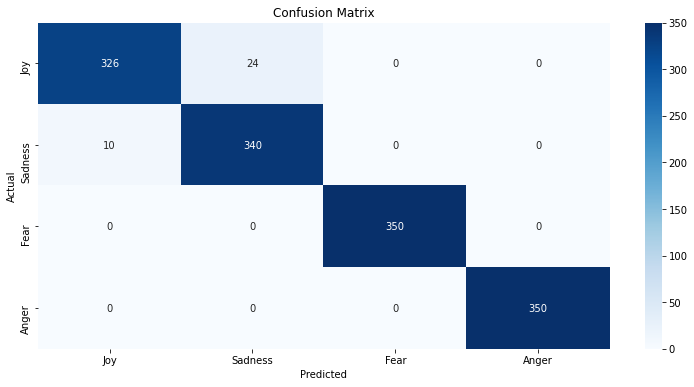

In [30]:
plot_confusion_matrix(actual_classes, predicted_classes, EMOTIONS)

In [31]:
save_object(model, f"{DATA_OUT_FOLDER}{MODEL_FILE}")

In [63]:
tfidf_features = tfidf_vectorizer.transform(df_reviews_val['Review Text Wordcloud']).toarray()

X = pd.concat([df_reviews_val.iloc[:,[3,5]], pd.DataFrame(tfidf_features)], axis=1)
#X = pd.DataFrame(tfidf_features)
y = df_reviews_val['Emotion Code']

actual_classes = y
predicted_classes = model.predict(X)
predicted_proba = model.predict_proba(X)

In [64]:
print(f"Accuracy: {accuracy_score(actual_classes, predicted_classes)}")

Accuracy: 1.0


Accuracy: 0.9316239316239316 including hints vs. Accuracy: 0.9230769230769231 just words

In [34]:
print("Classification report\n", classification_report(actual_classes, predicted_classes))

Classification report
               precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         3
        Fear       0.00      0.00      0.00         2
         Joy       0.98      0.89      0.93       324
     Sadness       0.32      0.82      0.46        22

    accuracy                           0.87       351
   macro avg       0.32      0.43      0.35       351
weighted avg       0.92      0.87      0.89       351



C:\Users\GHarrison\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report
               precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         3
        Fear       0.00      0.00      0.00         2
         Joy       0.93      1.00      0.96       324
     Sadness       1.00      0.14      0.24        22

    accuracy                           0.93       351
   macro avg       0.48      0.28      0.30       351
weighted avg       0.92      0.93      0.91       351

In [39]:
324/351

0.9230769230769231

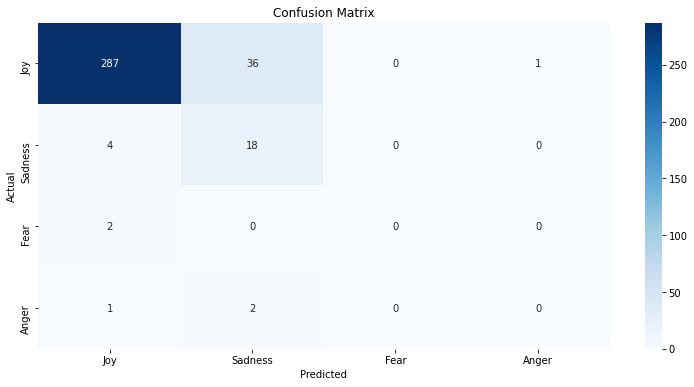

In [35]:
plot_confusion_matrix(actual_classes, predicted_classes, EMOTIONS)

TODO

1. Convert the predicted emotion codes back to textual emotions with a nice lambda function.
2. Append the predicted emotions and predicted probabilities into the clean data.
3. Take a look and see what the results look like.
4. Apply the results to all 23,000 rows (after removing the nulls).

Voila!!